# Libraries

In [1]:
import os  
import cv2           
from time import time
 
import pandas as pd
import numpy as np 

from random import shuffle  

from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,silhouette_score, homogeneity_score,adjusted_mutual_info_score,completeness_score,v_measure_score,adjusted_rand_score
from sklearn.preprocessing import StandardScaler


from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages as pdf
%matplotlib inline

In [2]:
data_dir='/Users/gowthamkommineni/Desktop/ML/project/101_ObjectCategories'
IMG_Size =50

# Loading Images and Image Preprocessing

In [3]:
def get_hog(image) : 
    winSize = (32,32)
    blockSize = (8,8)
    blockStride = (4,4)
    cellSize = (8,8)
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 1
    L2HysThreshold = 2e-1
    gammaCorrection = 0
    nlevels = 32
    signedGradient = True

    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,
                            cellSize,nbins,derivAperture,winSigma,histogramNormType,
                            L2HysThreshold,gammaCorrection,nlevels, signedGradient)
    winStride = (8,8)
    padding = (8,8)
    locations = ((10,20),)
    hist = hog.compute(image,winStride,padding,locations)
    hog = np.squeeze(hist)
    return hog

In [39]:
def create_categories():    
    train=[]
    b=[]
    i=0
    for categ in os.listdir(data_dir)[:10]:
        path = os.path.join(data_dir,categ)
        i=i+1
        for img in (os.listdir(path)):
            path2 = os.path.join(path,img)
            if (os.path.exists(path2)):
                gray = cv2.imread(path2,cv2.IMREAD_GRAYSCALE)
                img = cv2.equalizeHist(gray)
                imgb = cv2.GaussianBlur(img,(5,5),0)
                imge= cv2.Canny(imgb,100,200)
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
                img = cv2.morphologyEx(imge, cv2.MORPH_CLOSE, kernel)
                img,cnts, _ = cv2.findContours(imge.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                idx=0
                for c in cnts:
                    x,y,w,h = cv2.boundingRect(c)
                    if w>50 and h>50:
                        idx+=1
                        img=gray[y:y+h,x:x+w]

                orb = cv2.ORB_create()
                # find the keypoints with ORB
                kp = orb.detect(imgb,None)
                # compute the descriptors with ORB
                kp, des = orb.compute(imgb, kp)
                # draw only keypoints location,not size and orientation
                img2 = cv2.drawKeypoints(imgb.copy(),kp,color=(0,255,0),flags=0,outImage=None)
                img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(imgb, (IMG_Size,IMG_Size))
                img = img.reshape(IMG_Size*IMG_Size)
#                hist=get_hog(img)            # uncomment for HOG
                k=list(img) 
                stdsc = StandardScaler()
                k = stdsc.fit_transform(k)
                k=list(k)
#                 k.extend(hist)              #Uncomment for HOG
#                k=list(img)
                train.append(k)
                b.append(i)
    np.save('train_data.npy', train)
    train=pd.DataFrame(train)
    train['category']=b
    return train

In [ ]:
data=shuffle(create_categories())
train=data
print(data.shape)

# DataExploration                                    

In [42]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(train.iloc[:,:len(train.iloc[:,:-1].columns)])
data = pd.DataFrame(x_scaled)
data['category']=train['category']

In [43]:
train.describe()

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,category
count,1715.000000,1715.000000,1715.000000,1715.000000,1715.000000,1715.000000,1715.000000,1715.000000,1715.000000,1715.000000,...,1715.000000,1715.000000,1715.000000,1715.000000,1715.000000,1715.000000,1715.000000,1715.000000,1715.000000,1715.000000
mean,0.590008,0.481346,0.355663,0.223750,0.125257,0.022133,0.016261,0.065207,0.089330,0.111029,...,-0.069241,-0.108766,-0.121793,-0.125641,-0.073774,-0.013659,0.079525,0.216246,0.353890,4.019825
std,1.262753,1.245737,1.217291,1.196920,1.150138,1.089205,1.066501,1.045643,1.028303,1.014887,...,1.019566,1.025649,1.033644,1.047817,1.087154,1.132540,1.185046,1.237042,1.263207,2.538769
min,-5.058141,-5.082752,-3.286163,-5.082752,-5.131974,-5.082752,-5.181195,-5.107363,-4.984309,-5.255028,...,-2.183619,-2.205695,-2.360226,-2.382302,-2.514757,-2.647212,-2.757592,-2.757592,-2.757592,1.000000
25%,-0.551382,-0.664069,-0.857303,-0.988344,-0.986709,-1.019435,-0.988394,-0.879698,-0.828890,-0.759968,...,-0.979200,-1.023299,-1.059908,-1.101577,-1.116480,-1.111430,-1.104549,-1.000238,-0.870490,2.000000
50%,1.111345,0.918333,0.675547,0.466724,0.274761,0.088414,0.092525,0.181908,0.211570,0.231226,...,-0.050111,-0.146208,-0.197701,-0.199375,-0.084698,-0.009749,0.103404,0.335184,0.639024,3.000000
75%,1.695459,1.640520,1.552353,1.367480,1.187661,0.981141,0.936725,0.953883,0.936041,0.952430,...,0.804782,0.767533,0.773774,0.801802,0.907002,1.023611,1.211470,1.498011,1.610449,5.000000
max,3.365219,2.657360,2.675510,2.838862,2.838862,3.111116,2.893313,2.857012,2.657360,3.020364,...,2.067986,2.067986,2.639210,2.167304,2.711811,2.085942,2.085942,2.096267,2.657360,10.000000


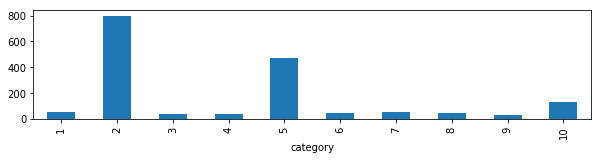

In [10]:
ax = train.groupby('category').size().plot(kind='bar', figsize=(10,2))

# Clustering and PCA Analysis

In [44]:
n_samples, n_features = data.shape
n_digits = len(np.unique(data.category))
labels = data.category
sample_size = len(data)

In [45]:
np.random.seed(42)

print(79 * '_')
print('% 9s' %    'init'
      '        time   inertia   homo    compl   v-meas   ARI    AMI    silhouette')

def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('% 9s   %.2fs    %i   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f'
          % (name, (time() - t0), estimator.inertia_,
             homogeneity_score(labels, estimator.labels_),
             completeness_score(labels, estimator.labels_),
             v_measure_score(labels, estimator.labels_),
             adjusted_rand_score(labels, estimator.labels_),
             adjusted_mutual_info_score(labels,  estimator.labels_),
             silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))
bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

#kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(79 * '_')

_______________________________________________________________________________
init        time   inertia   homo    compl   v-meas   ARI    AMI    silhouette
k-means++   8.02s    137442   0.169   0.116   0.138   0.044   0.107    0.038
   random   7.34s    137640   0.171   0.118   0.139   0.043   0.108    0.043
PCA-based   0.69s    138097   0.174   0.122   0.143   0.044   0.112    0.048
_______________________________________________________________________________


In [46]:
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=80)
kmeans.fit(reduced_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=80, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [47]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1

In [48]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

In [49]:
type(reduced_data)
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

In [50]:
type(Z)
Z = Z.reshape(xx.shape)

In [51]:
Z.shape

(189, 187)

# Plotting Cluster for 10 classes 

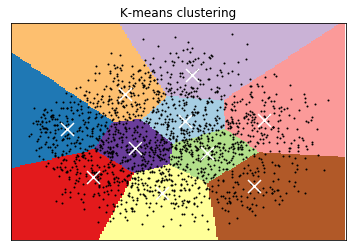

In [52]:
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
pdf.savefig("depth")
plt.show()

# Supervised Learning Models

In [28]:
train_input=train.iloc[:int(len(train)*0.7),:len(train.iloc[:,:-1].columns)].as_matrix()
train_output=train['category'][:int(len(train)*0.7)].as_matrix()
test_input=train.iloc[int(len(train)*0.7):,:len(train.iloc[:,:-1].columns)].as_matrix()
test_output=train['category'][int(len(train)*0.7):].as_matrix()

In [29]:
print(train_input.shape)
print(train_output.shape)
print(test_input.shape)
print(test_output.shape)

(1200, 2500)
(1200,)
(515, 2500)
(515,)


In [54]:
acc=[]
accdt=[]
accrt=[]
accsvm=[]
accnnet=[]
conf=[]
# clf5 = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(12,1), random_state=1)
# MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
#        beta_1=0.9, beta_2=0.999, early_stopping=False,
#        epsilon=1e-08, hidden_layer_sizes=(12,1), learning_rate='constant',
#        learning_rate_init=0.01, max_iter=200, momentum=0.9,
#        nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
#        solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
#        warm_start=False)
for n in range(1,40):
    clf1= KNeighborsClassifier(n_neighbors=3,weights='distance')
#     train_input=train.iloc[:int(len(train)*0.7),:len(train.iloc[:,:-1].columns)].as_matrix()
#     train_output=train['category'][:int(len(train)*0.7)].as_matrix()
#     test_input=train.iloc[int(len(train)*0.7):,:len(train.iloc[:,:-1].columns)].as_matrix()
#     test_output=train['category'][int(len(train)*0.7):].as_matrix()
#     #train=shuffle(create_categories(n))
    clf1.fit(train_input, train_output)
    predicted_output=clf1.predict(test_input)
    acc.append(accuracy_score(test_output, predicted_output)*100)
    conf.append(confusion_matrix(test_output, predicted_output))
#     #Decision Tree
#     clf2 = tree.DecisionTreeRegressor()
#     clf2 = clf2.fit(train_input, train_output)
#     predicted_output=clf2.predict(test_input)
#     accdt.append(accuracy_score(test_output, predicted_output)*100)
#     #Random Forest acc=[]
#     clf3 = RandomForestClassifier(n_jobs=4)
#     clf3.fit(train_input, train_output)
#     predicted_output=clf3.predict(test_input)
#     accrt.append(accuracy_score(test_output, predicted_output)*100)
#     #SVM
#     clf4 = svm.SVC(decision_function_shape='ovo')
#     clf4.fit(train_input, train_output)
#     predicted_output=clf4.predict(test_input)
#     accsvm.append(accuracy_score(test_output, predicted_output)*100)
#     #nnet
#     clf5.fit(train_input, train_output)                         
#     pred=clf5.predict(test_input)
#     accnnet.append(accuracy_score(test_output, pred)*100)

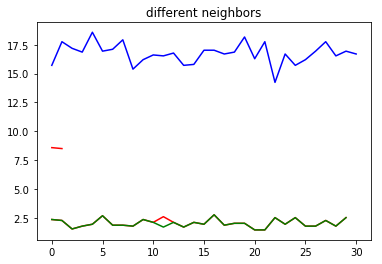

In [371]:
plt.plot(accsvm,color='red')
plt.plot(accnnet,color='green')
plt.plot(accdt,color='red')
plt.plot(accrt,color='blue')
plt.title("different neighbors")
plt.show('estimators')  
plt.close()

# Confusion Matrix 

In [337]:
conf_mat_ind=10

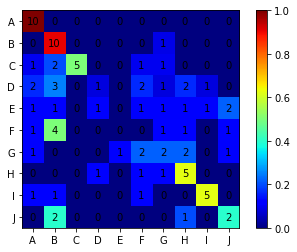

In [355]:
norm_conf = []
for i in conf[conf_mat_ind]:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = conf[conf_mat_ind].shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf[conf_mat_ind][x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

cb = fig.colorbar(res)
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
plt.xticks(range(width), alphabet[:width])
plt.yticks(range(height), alphabet[:height])
plt.savefig('confusion_matrix.png', format='png')

# Decision Tree

In [340]:
from sklearn import tree
clf = tree.DecisionTreeRegressor()
clf = clf.fit(train_input, train_output)
predicted_output=clf.predict(test_input)
accuracy_score(test_output, predicted_output)*100

55.533980582524265

# Random Forests

In [341]:
from sklearn.ensemble import RandomForestClassifier
acc=[]
for i in range(1,30):
    clf = RandomForestClassifier(n_jobs=i)
    clf.fit(train_input, train_output)
    predicted_output=clf.predict(test_input)
    acc.append(accuracy_score(test_output, predicted_output)*100)

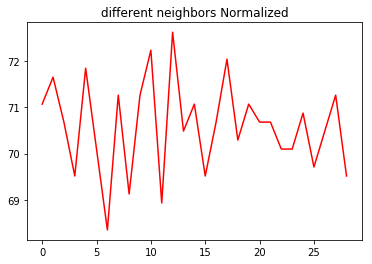

In [342]:
plt.plot(acc,color='red')
plt.title("different neighbors Normalized")
plt.show('estimators')  
plt.close()

# SVM

In [344]:
from sklearn import svm
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(train_input, train_output)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [347]:
predicted_output=clf.predict(test_input)
acchist_svm=accuracy_score(test_output, predicted_output)*100
conf.append(confusion_matrix(test_output, predicted_output))
   

In [346]:
acchist_svm

76.310679611650485

# Neaural Network

In [293]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(12,1), random_state=1)
clf.fit(train_input, train_output)                         
MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(12,1), learning_rate='constant',
       learning_rate_init=0.01, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(12, 1), learning_rate='constant',
       learning_rate_init=0.01, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [294]:
pred=clf.predict(test_input)
accuracy_score(test_output, pred)*100

42.33009708737864

# Feature Selection Using Random Forest 

In [33]:
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(train_input)
X_test_std = stdsc.transform(test_input)

/Users/gowthamkommineni/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [34]:
X_train_std

array([[-0.77663305, -0.88484567, -0.88420156, ..., -0.32056733,
        -0.43794186, -0.4826965 ],
       [-1.03161226, -0.33981009,  0.68322934, ..., -1.13580242,
        -1.40502547, -1.53609901],
       [ 0.84885945,  0.9319396 , -0.13314092, ..., -1.14681911,
        -1.23498879, -1.306645  ],
       ..., 
       [ 0.84885945,  0.9319396 ,  0.92269795, ..., -1.30105277,
        -1.39439817,  0.99832486],
       [-1.67968444, -1.52606401, -1.55906764, ...,  0.18620043,
        -0.27853248, -0.14894521],
       [-0.84037785, -0.69248018, -0.49234383, ...,  0.77008502,
         0.67792384,  0.56027629]])

In [ ]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = train[1:]

forest = RandomForestClassifier(n_estimators=10,
                                random_state=0,
                                n_jobs=-1)

forest.fit(train_input, train_output)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(train_input.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importances')
plt.bar(range(train_input.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(train_input.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, train_input.shape[1]])
plt.tight_layout()
plt.savefig('./random_forest.png', dpi=300)
plt.show()

In [155]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(forest, threshold=0.002, prefit=True)
X_selected = sfm.transform(train_input)
t=sfm.transform(test_input)

In [156]:
test_input=pd.DataFrame(t)
train_input=pd.DataFrame(X_selected)

In [157]:
train_input.head() 

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.031731,0.001088,0.003843,0.044395,0.065384,0.236945,0.682465,0.681927,0.000623,0.000302
1,0.564098,0.564098,0.002445,0.0,0.199291,0.503782,0.0,0.503782,0.183499,0.0,...,0.696857,0.542770,0.183477,0.272044,0.045329,0.032140,0.004454,0.001556,0.542770,0.542770
2,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.516723,0.704091,0.704091,0.038252,0.000000,0.003753,0.000583,0.000238,0.000052,0.002517
